<img src="../../../images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# Calibrating a Qubit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit import IBMQ
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

### Loading pulse backend
To run an OpenPulse experiment, at first we need to load a backend object of your quantum computing system with `open_pulse = True`. Then you will be able to program a `pulse` experiment using the pulse module. For more information on how to use the `pulse` module see this [tutorial](../terra/5_pulse_schedules.ipynb).

In this example we use `ibmq_armonk`, a one qubit system publically available on the IBM Q Experience.

In [ ]:
IBMQ.load_account()
ibmq_provider = IBMQ.get_provider(
    hub='provide_your_hub_name_here',
    group='provide_your_group_name_here',
    project='provide_your_project_name_here'
)
backend = ibmq_provider.get_backend('ibmq_armonk')

In [3]:
config = backend.configuration()
defaults = backend.defaults()

### Create pulses

User defined pulses can be created by using the `pulse.function` decorator. A python callback function which returns an `array_like` object can be used to create pulses. The first argument of the function should be `duration` specifing the number of data points. You are also able to get standard pulse templates from `pulse_lib`, and able to find calibrated pulses provided by the backend in `CmdDef`. In this notebook, we use a Gaussian pulse template from `pulse_lib.gaussian` and default measurement pulses from `CmdDef`.

In [4]:
circ_inst_map = defaults.circuit_instruction_map

measure = circ_inst_map.get('measure', qubits=config.meas_map[0])

In [5]:
# auto-phase the output measurement signal

def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)

In this notebook, we apply the backend default setting for drive and measurement pulse frequency. These frequencies are calibrated to be centered at resonanse frequency of corresponding qubit and readout resonator. To change this setting, you can refer to the [qiskit community tutorials](https://github.com/Qiskit/qiskit-community-tutorials).

## _Running Rabi Experiment_

In this experiment, we apply a Rabi drive pulse to qubit0 and measure a signal from the qubit by changing the amplitude of the pulse (`drive_amps`) from 0 to 0.05. The returned signal is integrated and averaged over 512 shot. A `boxcar` kernel is used to process measurement data (**note**: currently the hardware overrides this specification, to be implemented in future versions). The result is stored in `memory_slot[0]`.

In [6]:
# qubit to use for exeperiment
qubit = 0

# exp configuration
exps = 64
shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 1.0, exps)
drive_samples = 2048
drive_sigma = 256

# scaling factor for data returned by system
scale_factor=1e-10

Pulse commands are registered to `Schedule`s with information of `channel` and `start_time`. The channel information is provided by `PulseChannelSpec`. You can create your `Schedule` by using schedule composition methods or their syntactic sugar as shown below:  

- `|` (`union`): combine two `Schedule`s in parallel.
- `+` (`append`): add a `Schedule` right after a `Schedule` to be appended.
- `<<` (`shift`): shift `start_time` of `Schedule`.

All details are available in [Pulse Schedules](../terra/5_pulse_schedules.ipynb).
Created `Schedule`s can be combined into a single job.

In [7]:
# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, sigma=drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(pulse.DriveChannel(qubit))
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

We may plot any of the experiment schedules with:

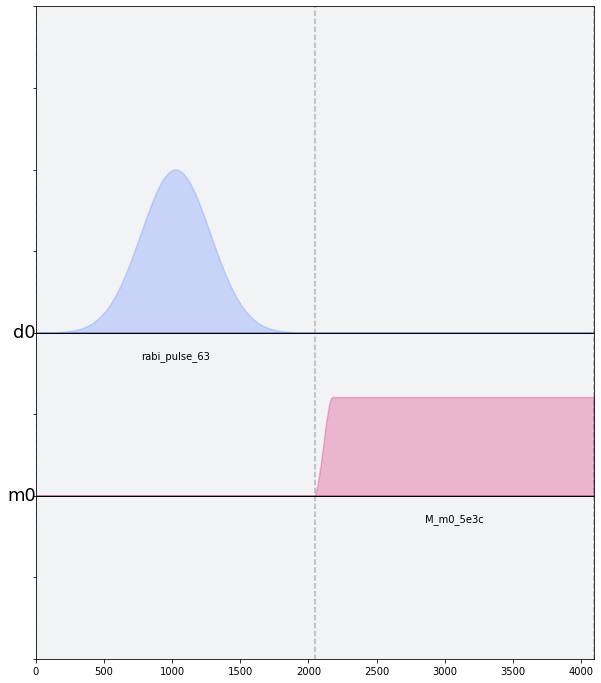

In [8]:
schedules[-1].draw(channels=[pulse.DriveChannel(qubit), pulse.MeasureChannel(qubit)],
                   label=True, plot_range=(0, 4096))

After `Schedule`s are now build for the Rabi experiment. We now assemble the Qobj to be sent to the quantum computing system. We use `meas_level=MeasLevel.KERNELED` (otherwise known as measurement level `meas_level=1`)  to get the default kernel integrated results from the system, and we automatically average them with `meas_return=MeasReturnType.AVERAGE` (otherwise known as `meas_return='avg'`).

In [9]:
rabi_qobj = assemble(schedules, backend, 
                     meas_level=MeasLevel.KERNELED, 
                     meas_return=MeasReturnType.AVERAGE, 
                     shots=shots)

After building our rabi experiment Qobj we now submit it to the backend to be run.

In [10]:
job = backend.run(rabi_qobj)

We receive a job object for our experiment which we may be used to monitor and get the results of the experiment.

In [11]:
job.job_id()

'5df01a6e60dba60011df07e4'

In [12]:
job.status()

<JobStatus.VALIDATING: 'job is being validated'>

We now ask for the result from the quantum computing system, which will block until completion (or timeout).

In [13]:
rabi_result = job.result(timeout=3600)

### Analyze the result

The result for our experiment is stored in `memory_slot[qubit]`. The returned data are the integrated values of the received and mixed down stimulus signal applied to the measured resonator averaged over all shots. Looking at the signal amplitude, we will observe an oscillation of the signal as a function of the drive amplitude. This is known as a Rabi oscillation and correspond to the qubit being periodically driven to its excited state. This is how we control our qubits.

Below we extract the data from the returned system `memory`. 

In [14]:
qubit_rabi_data = np.ones(exps, dtype=np.complex_)
for i in range(exps):
    qubit_rabi_data[i] = rabi_result.get_memory(i)[qubit]*scale_factor

We now plot and fit the extracted signal to a sinusoid.

Pi Amplitude 0.305795


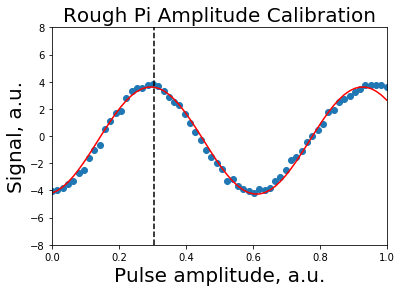

In [15]:
rabi_amp_data = get_amplitude(qubit_rabi_data)

fit_func = lambda x,A,B,Omega,phi: (A*np.cos(2*np.pi*x/Omega+phi)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, drive_amps, rabi_amp_data, [7.0,0.0,1.0,0])

#get the pi amplitude
pi_amp = (np.pi-fitparams[3])*fitparams[2]/4/np.pi

plt.scatter(drive_amps, rabi_amp_data)
plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='red')
plt.axvline(pi_amp, color='black', linestyle='dashed')
plt.xlim(0, 1)
plt.ylim(-8, 8)
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rough Pi Amplitude Calibration', fontsize=20)

print('Pi Amplitude %f'%(pi_amp))

From the fit we obtain the Rabi oscillation frequency. We may use this to extract the amplitude of a $\pi$ pulse. This is the required amplitude to drive the qubit from the ground state ($|0\rangle$) to the excited state ($|1\rangle$).

## _Measuring the IQ Distribution from the 0 and 1 States_

In this experiment, we observe a change of measured signals depending on a quantum state of qubit0. By setting `drive_amp` to `pi_amp` we previously obtained, we can apply a $\pi$-pulse to the qubit0. To observe a distribution on the IQ plane, we set `meas_return` to `single` .

In [17]:
# Create schedule
rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                amp=pi_amp,
                                sigma=drive_sigma,
                                name='pi_pulse')
    
# excited
excited_exp = pulse.Schedule(name='pi_exp')
excited_exp |= rabi_pulse(pulse.DriveChannel(qubit))
excited_exp |= measure << rabi_pulse.duration

# ground
ground_exp = pulse.Schedule(name='no_pi_exp')
ground_exp |= measure << rabi_pulse.duration

excited_exp_schedules = [ground_exp, excited_exp]

In [18]:
excited_exp_qobj = assemble(excited_exp_schedules, backend, meas_level=1,
                            meas_return='single', shots=shots)

In [ ]:
excited_exp_job = backend.run(excited_exp_qobj)

In [ ]:
excited_exp_job.status()

In [ ]:
excited_exp_result = excited_exp_job.result(timeout=3600)

### Analyze the result

In [ ]:
excited_exp_result.get_memory(0)[:, 0].shape

In [ ]:
ground_data = excited_exp_result.get_memory(0)[:, qubit]*scale_factor
excited_data = excited_exp_result.get_memory(1)[:, qubit]*scale_factor


In [ ]:
plt.scatter(np.real(ground_data), np.imag(ground_data), s=5, cmap='viridis',c='blue',alpha=0.5, label='|0>')
plt.scatter(np.real(excited_data), np.imag(excited_data), s=5, cmap='viridis',c='green',alpha=0.5, label='|1>')
ground_center = np.mean(ground_data)
excited_center = np.mean(excited_data)

plt.scatter(np.real(ground_center), np.imag(ground_center), c='blue', s=200, alpha=1.0)
plt.scatter(np.real(excited_center), np.imag(excited_center), c='green', s=200, alpha=1.0)

plt.title('Kernel integrated I-Q scatter plot', fontsize=20)
plt.legend(loc='upper right')
plt.xlabel('I (a.u.)', fontsize=16)
plt.ylabel('Q (a.u.)', fontsize=16)

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright